In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import torch
import gpytorch
from gpytorch.kernels import RBFKernel, ScaleKernel


class ExactGP(gpytorch.models.ExactGP):
    def __init__(self,
                 train_x,
                 train_y,
                 likelihood=gpytorch.likelihoods.GaussianLikelihood(
                     noise_constraint=gpytorch.constraints.GreaterThan(0.0)
                ),
                mean_module=gpytorch.means.ConstantMean(),
                covar_module=ScaleKernel(RBFKernel())
        ):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = mean_module
        self.covar_module = covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def plot_1d_regression(
    x_star,
    model,
    ax=None,
    f_true=None,
    num_samples=10
):
    """Plot the posterior predictive.
    
    Arguments
    x_start  --  The test points on which to evaluate.
    model    --  The trained model.
    
    Keyword Arguments
    ax          --  An axes object to write on.
    f_true      --  The true function.
    num_samples --  The number of samples.
    """
    f_star = model(x_star)
    m_star = f_star.mean
    v_star = f_star.variance
    y_star = model.likelihood(f_star)
    yv_star = y_star.variance

    f_lower = (
        m_star - 2.0 * torch.sqrt(v_star)
    )
    f_upper = (
        m_star + 2.0 * torch.sqrt(v_star)
    )
    
    y_lower = m_star - 2.0 * torch.sqrt(yv_star)
    y_upper = m_star + 2.0 * torch.sqrt(yv_star)

    if ax is None:
        fig, ax = plt.subplots()
    
    ax.plot(model.train_inputs[0].flatten().detach(),
            model.train_targets.detach(),
            'kx',
            markersize=10,
            markeredgewidth=2,
            label='Observations'
    )

    ax.plot(
        x_star,
        m_star.detach(),
        lw=2,
        label='$m_n(x)$',
        color=sns.color_palette()[0]
    )
    
    ax.fill_between(
        x_star.flatten().detach(),
        f_lower.flatten().detach(),
        f_upper.flatten().detach(),
        alpha=0.5,
        label='$f(\mathbf{x}^*)$ 95% pred.',
        color=sns.color_palette()[0]
    )

    ax.fill_between(
        x_star.detach().flatten(),
        y_lower.detach().flatten(),
        f_lower.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label='$y^*$ 95% pred.'
    )
    ax.fill_between(
        x_star.detach().flatten(),
        f_upper.detach().flatten(),
        y_upper.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label=None
    )

    
    if f_true is not None:
        ax.plot(
            x_star,
            f_true(x_star),
            'm-.',
            label='True function'
        )
        
    if num_samples > 0:
        f_post_samples = f_star.sample(
            sample_shape=torch.Size([10])
        )
        ax.plot(
            x_star.numpy(),
            f_post_samples.T.detach().numpy(),
            color="red",
            lw=0.5
        )
        # This is just to add the legend entry
        ax.plot(
            [],
            [],
            color="red",
            lw=0.5,
            label="Posterior samples"
        )
        
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    plt.legend(loc='best', frameon=False)
    sns.despine(trim=True)
    
    return m_star, v_star


def train(model, train_x, train_y, n_iter=10, lr=0.1):
    """Train the model.

    Arguments
    model   --  The model to train.
    train_x --  The training inputs.
    train_y --  The training labels.
    n_iter  --  The number of iterations.
    """
    model.train()
    optimizer = torch.optim.LBFGS(model.parameters(), line_search_fn='strong_wolfe')
    likelihood = model.likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    def closure():
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        return loss
    for i in range(n_iter):
        loss = optimizer.step(closure)
        if (i + 1) % 1 == 0:
            print(f'Iter {i + 1:3d}/{n_iter} - Loss: {loss.item():.3f}')
    model.eval()


def plot_iaf(
    x_star,
    gpr,
    alpha,
    alpha_params={},
    ax=None,
    f_true=None,
    iaf_label="Information Acquisition Function"
):
    """Plot the information acquisition function.
    
    Arguments
    x_star       -- A set of points to plot on.
    gpr          -- A rained Gaussian process regression
                    object.
    alpha        -- The information acquisition function.
                    This assumed to be a function of the
                    posterior mean and standard deviation.
              
    Keyword Arguments
    ax           -- An axes object to plot on.
    f_true       -- The true function - if available.
    alpha_params -- Extra parameters to the information
                    acquisition function.
    ax           -- An axes object to plot on.
    f_true       -- The true function - if available.
    iaf_label    -- The label for the information acquisition
                    function. Default is "Information Acquisition".
    
    The evaluation of the information acquisition function
    is as follows:
    
        af_values = alpha(mu, sigma, y_max, **alpha_params)

    """
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.set_title(
        ", ".join(
            f"{n}={k:.2f}"
            for n, k in alpha_params.items()
            )
    )
    
    m, v = plot_1d_regression(
        x_star,
        gpr,
        ax=ax,
        f_true=f_true,
        num_samples=0
    )
    
    sigma = torch.sqrt(v)
    af_values = alpha(m, sigma, gpr.train_targets.numpy().max(), **alpha_params)
    next_id = torch.argmax(af_values)
    next_x = x_star[next_id]
    af_max = af_values[next_id]
    
    ax2 = ax.twinx()
    ax2.plot(x_star, af_values.detach(), color=sns.color_palette()[1])
    ax2.set_ylabel(
        iaf_label,
        color=sns.color_palette()[1]
    )
    plt.setp(
        ax2.get_yticklabels(),
        color=sns.color_palette()[1]
    )
    ax2.plot(
        next_x * np.ones(100),
        torch.linspace(0, af_max.item(), 100),
        color=sns.color_palette()[1],
        linewidth=1
    )


def maximize(
    f,
    model,
    X_design,
    alpha,
    alpha_params={},
    max_it=10,
    optimize=False,
    plot=False,
    **kwargs
):
    """Optimize a function using a limited number of evaluations.
    
    Arguments
    f            -- The function to optimize.
    gpr          -- A Gaussian process model to use for representing
                    our state of knowledge.
    X_design     -- The set of candidate points for identifying the
                    maximum.
    alpha        -- The information acquisition function.
                    This assumed to be a function of the
                    posterior mean and standard deviation.
    
    Keyword Arguments
    alpha_params -- Extra parameters to the information
                    acquisition function.
    max_it       -- The maximum number of iterations.
    optimize     -- Whether or not to optimize the hyper-parameters.
    plot         -- Determines how often to plot. Make it one
                    to plot at each iteration. Make it max_it
                    to plot at the last iteration.
                    
    The rest of the keyword arguments are passed to plot_iaf().
    """
    af_all = []
    for count in range(max_it):
        # Predict
        f_design = model(X_design)
        m = f_design.mean
        sigma2 = f_design.variance
        sigma = torch.sqrt(sigma2)
        
        # Evaluate information acquisition function
        y_train = model.train_targets.numpy()
        af_values = alpha(
            m,
            sigma,
            y_train.max(),
            **alpha_params
        )
        
        # Find best point to include
        i = torch.argmax(af_values)
        af_all.append(af_values[i])
        
        new_x = X_design[i:(i+1)].float()
        new_y = f(new_x)
        train_x = torch.cat([model.train_inputs[0], new_x[:, None]])
        train_y = torch.cat([model.train_targets, new_y])
        model.set_train_data(train_x, train_y, strict=False)
        
        if optimize:
            train(model, train_x, train_y, n_iter=100, lr=0.1)
        else:
            model.train()
            model.eval()
        
        # Plot if required
        if count % plot == 0:
            if "ax" in kwargs:
                ax = kwargs[ax]
            else:
                fig, ax = plt.subplots()
            plot_iaf(
                X_design,
                model,
                alpha,
                alpha_params=alpha_params,
                f_true=f,
                ax=ax,
                **kwargs
            )
            ax.set_title(
                f"N={count}, " + ax.get_title()
            )
    return af_all


def mui(m, sigma, ymax, psi=1.96):
    """The maximum upper interval acquisition function."""
    return m + psi * sigma


def poi(m, sigma, ymax, psi=0.):
    """Return the probability of improvement.
    
    Arguments
    m     -- The predictive mean at the test points.
    sigma -- The predictive standard deviation at
             the test points.
    ymax  -- The maximum observed value (so far).
    psi   -- A parameter that controls exploration.
    """
    return torch.distributions.Normal(0, 1).cdf((m - ymax - psi) / sigma)


def ei(m, sigma, ymax):
    """Return the expected improvement.
    
    Arguments
    m     -- The predictive mean at the test points.
    sigma -- The predictive standard deviation at
             the test points.
    ymax  -- The maximum observed value (so far).
    """
    diff = m - ymax
    u = diff / sigma
    ei = ( diff * torch.distributions.Normal(0, 1).cdf(u) + 
          sigma * torch.distributions.Normal(0, 1).log_prob(u).exp()
    )
    ei[sigma <= 0.] = 0.
    return ei

In [ ]:
!pip install gpytorch

# Quantifying Epistemic Uncertainty about the Solution of the Optimization problem

We wish to quantify the epistemic uncertainty in the solution of an optimization problem.

Let's start by recreating our working example:

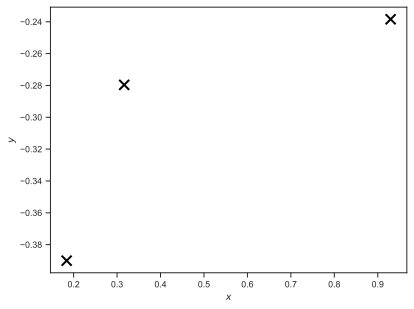

In [2]:
def f(x):
    """A function to optimize."""
    return -4 * (1. - np.sin(6 * x + 8 * np.exp(6 * x - 7.))) 

np.random.seed(12345)

n_init = 3

X = np.random.rand(n_init)
Y = f(X)

plt.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
plt.xlabel('$x$')
plt.ylabel('$y$');

Let's fit the usual GP:

/Users/ibilion/.pyenv/versions/3.11.6/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/ibilion/.pyenv/versions/3.11.6/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


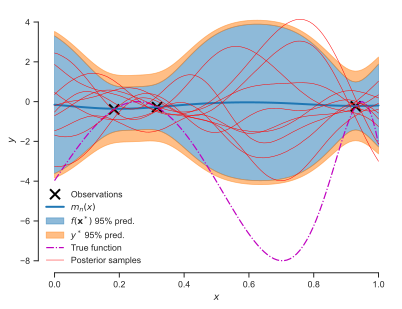

In [4]:
train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()
model = ExactGP(train_x, train_y)

model.covar_module.base_kernel.lengthscale = 0.15
model.covar_module.outputscale = 4.0
model.likelihood.noise = 0.4
model.eval()

x = torch.linspace(0, 1, 100)
plot_1d_regression(
    x,
    model,
    f_true=f
);

Imagine that you have observed data $\mathcal{D}_n$.
How certain are you about the location of the maximum?
If $n$ is small, you can be more confident.
How do you quantify this epistemic uncertainty?
Notice that the maximum and the location of the maximum are *operators* acting on $f$:

$$
f^* := \max[f] := \max_{\mathbf{x}} f(\mathbf{x}),
$$

and

$$
\mathbf{x}^* := \mathbf{X}^*[f] := \arg\max_{\mathbf{x}} f(\mathbf{x}),
$$

respectively.
So since we are uncertain about $f$, we will be unsure about $f^*$ and $\mathbf{x}^*$.
In particular, we want to quantify the joint probability density $p(\mathbf{x}^*, f^*|\mathcal{D}_n)$.
Here is what is the formal answer:

$$
p(\mathbf{x}^*, f^*|\mathcal{D}_n) = \int \delta(\mathbf{x}^* - \mathbf{X}^*[f])\delta(f^*-\max[f])p(f(\cdot)|\mathcal{D}_n)df(\cdot).
$$

Of course, this is not technically correct because you cannot integrate over a function this way.
The correct way to write this mathematically is to use conditional expectations:

$$
p(\mathbf{x}^*, f^*|\mathcal{D}_n) = \mathbb{E}\left[\delta(\mathbf{x}^* - \mathbf{X}^*[f])\delta(f^*-\max[f])|\mathcal{D}_n\right],
$$

where the expectation is taken over $f(\cdot)$ conditional on $\mathcal{D}_n$.
In any case, there are two questions:
+ What does this mean?
+ How do you compute it?

First, what does it mean?
To understand this, you need to pay attention to the delta function.
Take for example $\delta(f^* - \max[f])$. What does it do?
It just hits a counter whenever $\max[f]$ matches $f^*$ precisely as you take the expectation over $f(\cdot)$.

Second, how do you compute it?
The simplest way to do this is through sampling.
You just sample functions from $p(f(\cdot)|\mathcal{D}_n)$, and you find their maximum location of the maximum.
Of course, you cannot sample a function.
You sample the *function values* at a finite but dense number of input points and find the maximum amongst these points.
Once you get these samples, you look at their histogram.

Okay, let's do it for our working example:

/Users/ibilion/.pyenv/versions/3.11.6/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/ibilion/.pyenv/versions/3.11.6/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


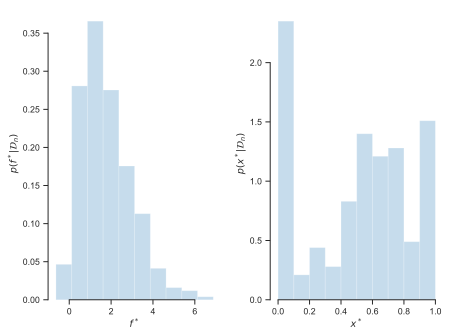

In [24]:
def plot_max_and_argmax(gpr, X_design, n_samples=1000):
    """Plot histograms of the max and argmax of the function represented by the model gpr.
    
    Arguments
    gpr      -- A trained Gaussian process object.
    X_design -- A set of points to evaluate the response on.
    
    Keyword Arguments
    n_samples -- The number of samples to take to make the histograms.
    """
    f_star = gpr(X_design)
    f_samples = f_star.sample(sample_shape=torch.Size([n_samples])).numpy()
    max_f_samples = np.max(f_samples, axis=1)
    x_star_samples = X_design.numpy()[np.argmax(f_samples, axis=1)]
    
    fig, ax = plt.subplots(1,2)
    ax[0].hist(max_f_samples, density=True, alpha=0.25)
    ax[0].set_xlabel('$f^*$')
    ax[0].set_ylabel('$p(f^*|\mathcal{D}_n)$')
    
    ax[1].hist(x_star_samples, density=True, alpha=0.25)
    ax[1].set_xlabel('$x^*$')
    ax[1].set_ylabel('$p(x^*|\mathcal{D}_n)$')
    
    plt.tight_layout()
    sns.despine(trim=True)
    
    return fig, ax

plot_max_and_argmax(model, x);

Let's do a few iterations ofour optimization algorithm and repeat that plot.

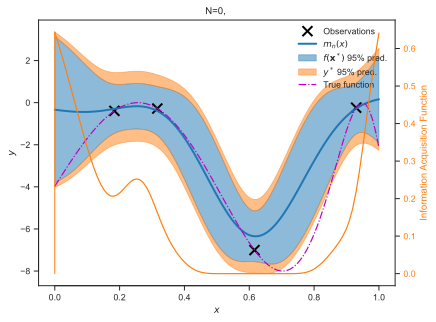

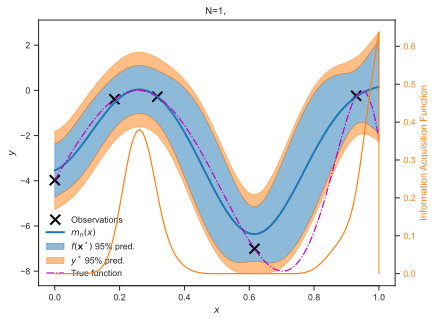

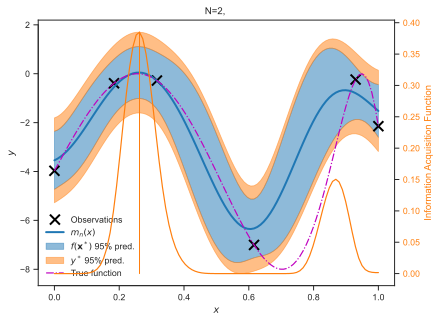

In [28]:
train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()
model = ExactGP(train_x, train_y)

model.covar_module.base_kernel.lengthscale = 0.15
model.covar_module.outputscale = 4.0
model.likelihood.noise = 0.4
model.eval()

x = torch.linspace(0, 1, 100)
af_all = maximize(
    f,
    model,
    x,
    ei,
    max_it=3,
    plot=1
)

Here it is again:

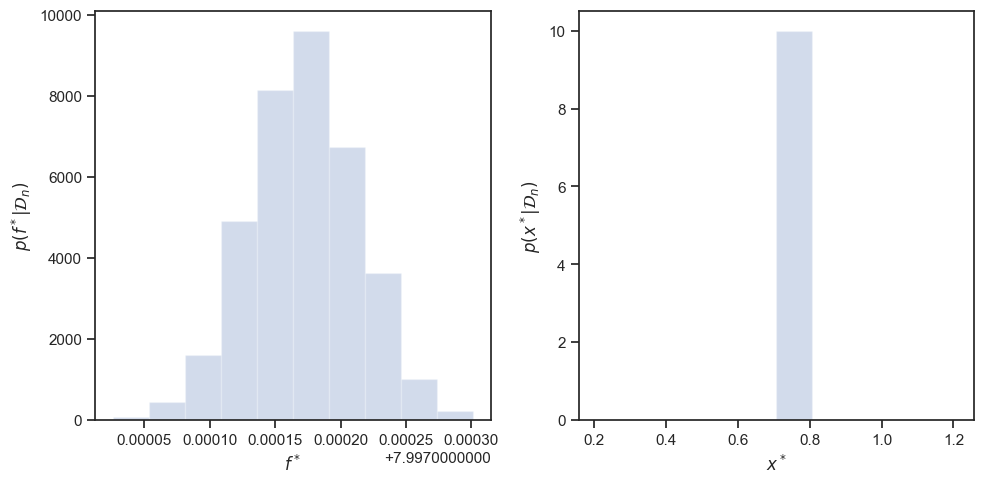

In [6]:
plot_max_and_argmax(gpr, x_star);

### Questions
+ How does the epistemic uncertainty about the optimization problem change when you decrease the number of initial samples?

+ Try changing the number of initial samples to a very small number. Does the algorithm work?